# 不同训练 Episode 数量的 SmolVLA 成功率分析


本笔记用于汇总不同训练 Episode 数量下的 SmolVLA 抓取成功率，并进一步分析方块位置分布。

- 请确保下方 `EXPERIMENT_GROUPS` 中的 Notebook 路径与实际评估结果一致。
- 如果新增了实验或重跑了测试，只需更新路径并重新执行对应的单元格即可。


In [1]:
%matplotlib inline
from pathlib import Path

import numpy as np

from analyse_utiles import (
    aggregate_success_rates,
    compute_min_distances,
    load_dataset_block_positions,
    load_dataset_durations,
    load_notebook_test_result,
    plot_block_position_comparison,
    plot_success_rate_summary,
    summarise_distance_stats,
)

In [3]:
# 根据实际的评估 Notebook 更新路径
EXPERIMENT_GROUPS = {
    "20 demos": [
        Path("lerobot_Test_result/Test_remove_block_random_20demos.ipynb"),
    ],
    "50 demos": [
        Path("lerobot_Test_result/Test_remove_block_random_50demos.ipynb"),
    ],
    "20 demos fixed": [
        Path("lerobot_Test_result/Test_remove_fixed_block.ipynb"),  # TODO: 更新为真实路径
    ],
    
}
EXPERIMENT_GROUPS

{'20 demos': [PosixPath('lerobot_Test_result/Test_remove_block_random_20demos.ipynb')],
 '50 demos': [PosixPath('lerobot_Test_result/Test_remove_block_random_50demos.ipynb')],
 '20 demos fixed': [PosixPath('lerobot_Test_result/Test_remove_fixed_block.ipynb')]}

In [4]:

summary = aggregate_success_rates(EXPERIMENT_GROUPS)

rows = []
for group, data in summary.items():
    rates = data.get("success_rates", [])
    rows.append({
        "Group": group,
        "Runs": data.get("num_runs", 0),
        "Mean Success Rate": round(data["mean_success_rate"], 2) if data.get("mean_success_rate") is not None else None,
        "Std Success Rate": round(data["std_success_rate"], 2) if data.get("std_success_rate") is not None else None,
        "Per Run (%)": ", ".join(f"{rate:.2f}" for rate in rates) if rates else "",
    })

try:
    import pandas as pd
    display(pd.DataFrame(rows))
except Exception:
    from pprint import pprint
    pprint(rows)


,Group,Runs,Mean Success Rate,Std Success Rate,Per Run (%)
0,20 demos,1,35.0,0.0,35.00
1,50 demos,1,0.0,0.0,0.00
2,20 demos fixed,1,100.0,0.0,100.00


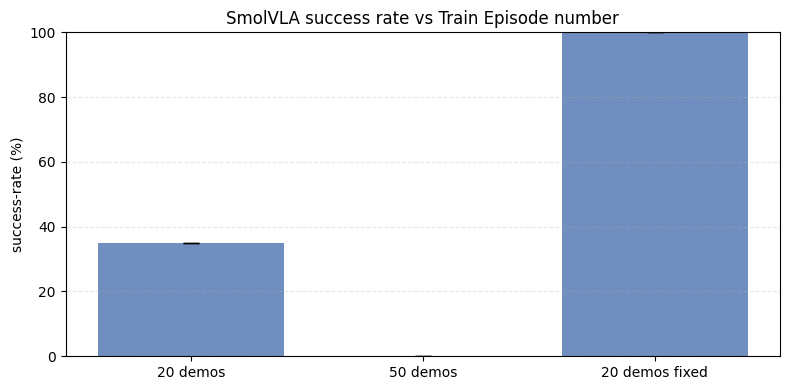

In [5]:

import matplotlib.pyplot as plt

if any(data.get("success_rates") for data in summary.values()):
    ax = plot_success_rate_summary(summary, title="SmolVLA success rate vs Train Episode number")
    plt.tight_layout()
    plt.show()
else:
    print("No success-rate data found. Please verify evaluation logs.")


## 方块位置与数据集示例点的距离分析

Dataset samples loaded: 20
Success positions collected: 0
Failure/timeout positions collected: 20


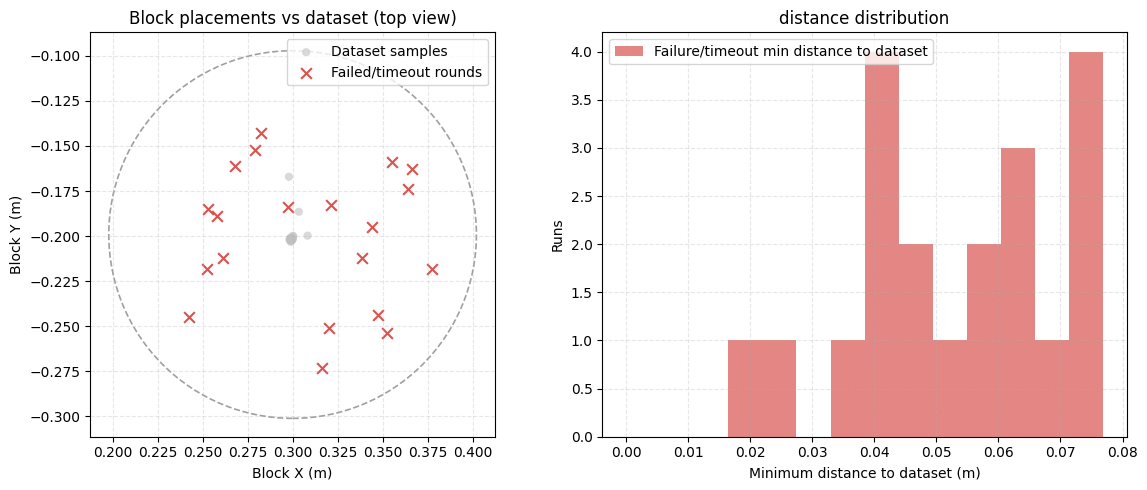

Success distance stats:
  No data
Failure/timeout distance stats:
{'mean': 0.05308158235980035, 'median': 0.0546371180684206, 'std': 0.016980274703420825, 'min': 0.01953182648073506, 'max': 0.07686001998239922}

Evaluation success timing (15-episode run): No data
Dataset demo durations (seed_000):
  count: 20
  mean : 8.4s
  min  : 6.9s
  max  : 15.4s


In [6]:
# Focus on demo_data_language_subsets_nbr15/seed_000 dataset and 15-episode evaluation
DATASET_ROOT = Path("demo_data_language")
TARGET_GROUP = "50 episodes"
TARGET_NOTEBOOK = Path("Test_remove_block_random.ipynb")

# Load dataset block positions (XYZ only) and durations (seconds)
dataset_positions = load_dataset_block_positions(DATASET_ROOT)
dataset_durations = load_dataset_durations(DATASET_ROOT)
if dataset_positions.size == 0:
    print(f"No block_pose_log.json data found under {DATASET_ROOT}.")

# Ensure summary includes the target notebook result
runs_15 = []
if TARGET_GROUP in summary:
    runs_15 = summary[TARGET_GROUP].get("runs", [])

# Fallback: manually load notebook if aggregator missed it (e.g., path change)
if not runs_15 and TARGET_NOTEBOOK.exists():
    runs_15 = [load_notebook_test_result(TARGET_NOTEBOOK)]

if not runs_15:
    print("No evaluation runs available for the 15-episode setting. Check paths above.")
else:
    success_list = []
    failure_list = []
    success_time_list = []
    for run in runs_15:
        success_pos = run.success_positions()
        if success_pos.size:
            success_list.append(success_pos)
        failure_pos = run.failure_positions()
        if failure_pos.size:
            failure_list.append(failure_pos)
        timeout_pos = run.timeout_positions()
        if timeout_pos.size:
            failure_list.append(timeout_pos)
        if run.success_times:
            success_time_list.extend(run.success_times)

    success_positions = np.vstack(success_list) if success_list else np.empty((0, 3))
    failure_positions = np.vstack(failure_list) if failure_list else np.empty((0, 3))

    print(f"Dataset samples loaded: {len(dataset_positions)}")
    print(f"Success positions collected: {len(success_positions)}")
    print(f"Failure/timeout positions collected: {len(failure_positions)}")

    if dataset_positions.size == 0:
        print("Cannot compare positions without dataset samples.")
    elif success_positions.size == 0 and failure_positions.size == 0:
        print("No success or failure block positions parsed from the target evaluation.")
    else:
        ax_xy, ax_hist = plot_block_position_comparison(
            dataset_positions=dataset_positions,
            success_positions=success_positions,
            failure_positions=failure_positions,
        )
        plt.tight_layout()
        plt.show()

        success_dist = compute_min_distances(dataset_positions, success_positions)
        failure_dist = compute_min_distances(dataset_positions, failure_positions)

        success_stats = summarise_distance_stats(success_dist)
        failure_stats = summarise_distance_stats(failure_dist)

        print("Success distance stats:")
        print(success_stats if success_stats else "  No data")
        print("Failure/timeout distance stats:")
        print(failure_stats if failure_stats else "  No data")

        if success_dist.size and failure_dist.size:
            print("Distance comparison (mean difference success - failure):")
            print(float(np.mean(success_dist) - np.mean(failure_dist)))

    # Timing statistics comparison
    if success_time_list:
        success_time_array = np.asarray(success_time_list)
        print("\nEvaluation success timing (15-episode run):")
        print(f"  count: {success_time_array.size}")
        print(f"  mean : {success_time_array.mean():.1f}s")
        print(f"  min  : {success_time_array.min():.1f}s")
        print(f"  max  : {success_time_array.max():.1f}s")
    else:
        print("\nEvaluation success timing (15-episode run): No data")

    if dataset_durations.size:
        print("Dataset demo durations (seed_000):")
        print(f"  count: {dataset_durations.size}")
        print(f"  mean : {dataset_durations.mean():.1f}s")
        print(f"  min  : {dataset_durations.min():.1f}s")
        print(f"  max  : {dataset_durations.max():.1f}s")
    else:
        print("Dataset demo durations (seed_000): No data")
